In [1]:
import os
import fastmri
from fastmri.data import transforms
import numpy as np
import torch
import pytorch_lightning as pl
import PIL
import pandas as pd
import h5py
from matplotlib import pyplot as plt
import nibabel as nib
import pydicom

%matplotlib inline

In [2]:
base_folder = "/data/projects/dwi_aisd/dicoms"
file_names = os.listdir(base_folder)
output_dir = "/data/projects/dwi_aisd/DWIs_nii/"

In [3]:
import dicom2nifti

for dicom_id in file_names:
    in_dir = os.path.join(base_folder, dicom_id, "DWI")
    dicom_files = os.listdir(in_dir)
    out_name = os.path.join(output_dir, dicom_id + "_DWI" + ".nii.gz")
    if os.path.isfile(out_name):
        continue
    if not os.path.isfile(os.path.join(in_dir, dicom_files[0])):
        for i in dicom_files:
            in_dir = os.path.join(base_folder, dicom_id, "DWI", i)
            out_name = os.path.join(output_dir, dicom_id + "_" + i + "_DWI" + ".nii.gz")
            if os.path.isfile(out_name):
                continue
            dicom2nifti.dicom_series_to_nifti(in_dir, out_name, reorient_nifti=False)
    else:
        dicom2nifti.dicom_series_to_nifti(in_dir, out_name, reorient_nifti=False)

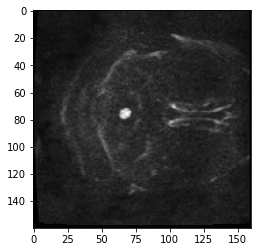

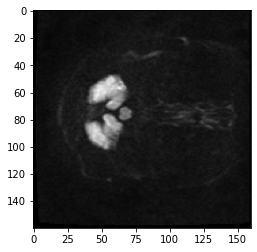

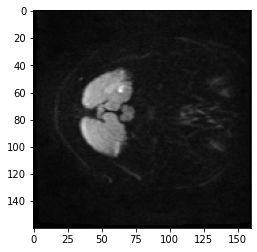

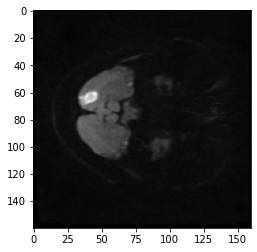

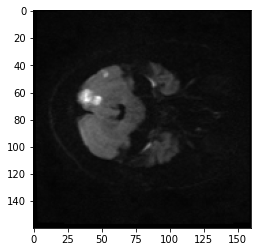

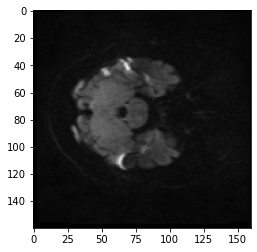

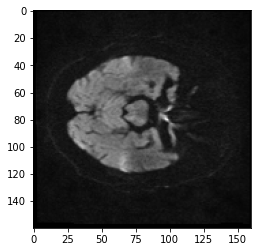

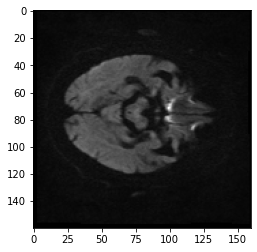

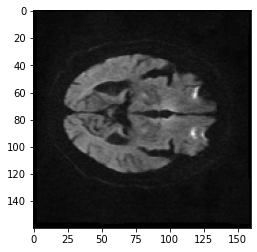

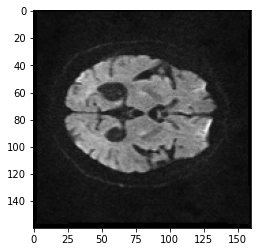

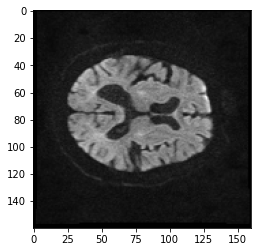

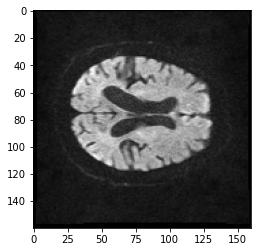

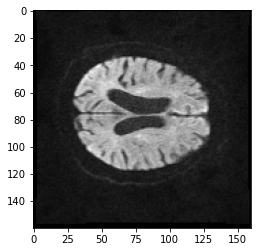

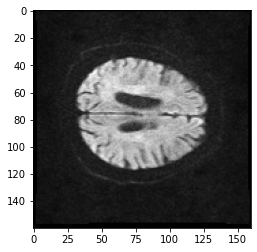

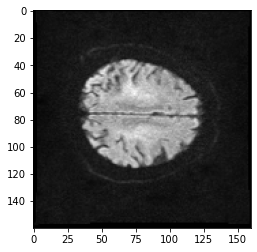

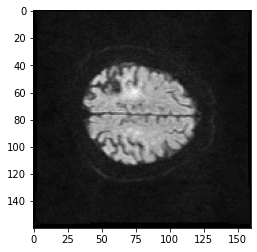

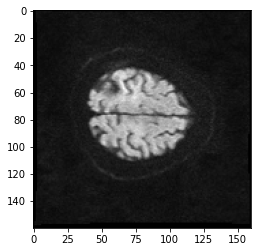

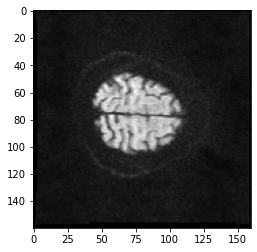

In [4]:
nii_file_path = "/data/projects/dwi_aisd/DWIs_nii/0019983_DWI.nii.gz"
nii = nib.load(nii_file_path)
nii = nib.as_closest_canonical(nii)
nii_numpy = np.array(nii.dataobj)
transform = np.array(nib.load(nii_file_path).affine)
for i in range(18):
    plt.imshow(nii_numpy[:, :, i], cmap="gray")
    plt.show()

(512, 512, 17)
0.0 0.20665069947759784 1.0


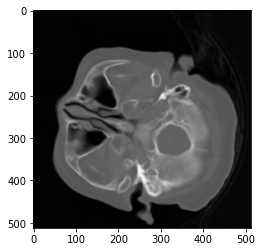

0.0 0.21508874764077796 1.0


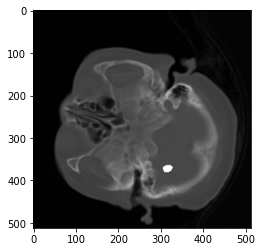

0.0 0.19608420663144321 1.0


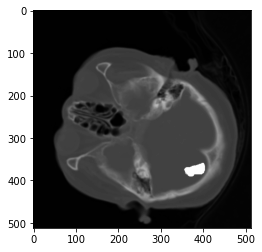

0.0 0.21771877145027108 1.0


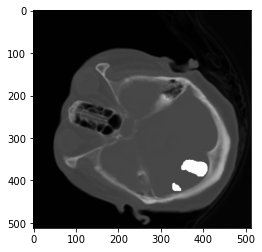

0.0 0.22403114652794215 1.0


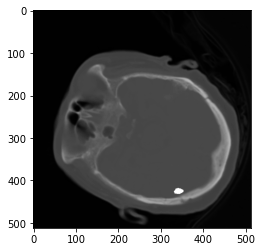

0.0 0.230916638240636 1.0


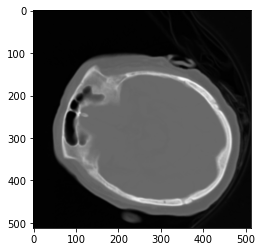

0.0 0.2269276658755366 1.0


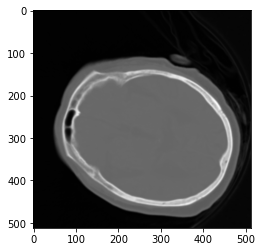

0.0 0.22045692073488693 1.0


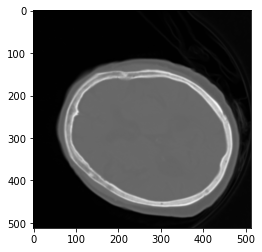

0.0 0.22681945825501848 1.0


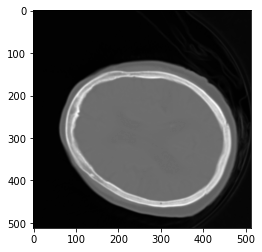

0.0 0.22106238374492634 1.0


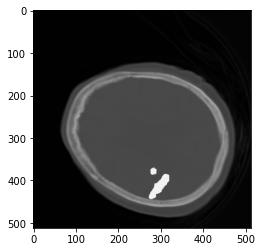

0.0 0.21109203479793215 1.0


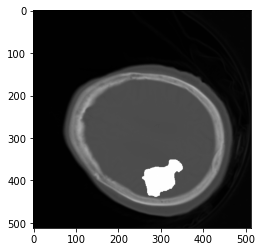

0.0 0.20582491964907257 1.0


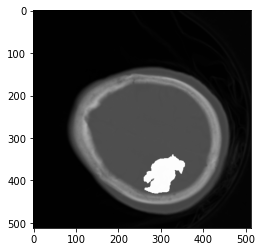

0.0 0.19751425088788363 1.0


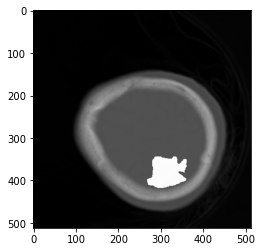

0.0 0.17930175760433098 1.0


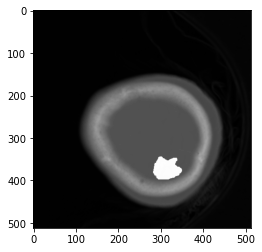

0.0 0.15720365812193673 1.0


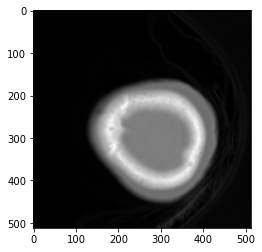

0.0 0.11588837943687569 1.0


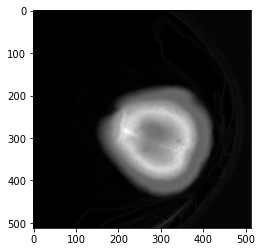

0.0 0.08770266802942166 1.0


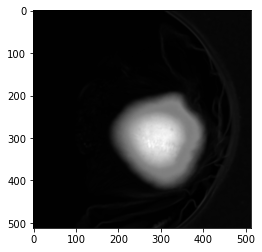

In [5]:
ct_file_path = "/data/projects/dwi_aisd/CTs_laura/0019983_CT.nii.gz"
mask_file_path = "/data/projects/dwi_aisd/Masks_laura/0019983_mask.nii.gz"
ct_numpy = np.array(nib.load(ct_file_path).dataobj)
mask_numpy = np.array(nib.load(mask_file_path).dataobj)
print(ct_numpy.shape)
for i in range(17):
    ct = ct_numpy[:, :, i]
    ct = (ct - ct.mean())/ct.std()
    ct -= np.min(ct)
    ct = np.divide(ct, np.max(ct))
    print(np.min(ct), np.mean(ct), np.max(ct))
    mask = mask_numpy[:, :, i]/(max(1, np.max(mask_numpy[:, :, i])))
    plt.imshow(ct + mask, cmap="gray")
    plt.show()

In [6]:
import itk
from itkwidgets import view, compare, checkerboard

def register_image_mask(fixed_image_file_path, moving_image_file_path, mask_file_path, default_parameter_map='rigid', return_moving_image=False):
    fixed_image = itk.imread(fixed_image_file_path).astype(itk.F)
    fixed_image.SetOrigin([0 for i in range(len(fixed_image.shape))])
    if len(fixed_image.shape) == 4:
        extractFilter = itk.ExtractImageFilter[fixed_image, itk.Image[itk.F, 3]].New()

        extractFilter.SetDirectionCollapseToSubmatrix()
        inputRegion = fixed_image.GetLargestPossibleRegion()

        size = inputRegion.GetSize()
        size[3] = 0
        index = inputRegion.GetIndex()
        desiredRegion = inputRegion 
        desiredRegion.SetSize(size)
        desiredRegion.SetIndex(index)

        extractFilter.SetExtractionRegion(desiredRegion)
        extractFilter.SetInput(fixed_image)
        fixed_image = extractFilter.GetOutput()

    moving_image = itk.imread(moving_image_file_path).astype(itk.F)
    mask = itk.imread(mask_file_path).astype(itk.F)

    moving_image, _ = resample(moving_image, itk.size(fixed_image))
    mask, origin = resample(mask, itk.size(fixed_image), interpolator=itk.NearestNeighborInterpolateImageFunction)
    fixed_image.SetOrigin([0 for i in range(len(fixed_image.shape))])

    parameter_object = itk.ParameterObject.New()
    default_rigid_parameter_map = parameter_object.GetDefaultParameterMap(default_parameter_map)
    parameter_object.AddParameterMap(default_rigid_parameter_map)

    elastix_object = itk.ElastixRegistrationMethod.New(fixed_image, moving_image)
    elastix_object.SetFixedImage(fixed_image)
    elastix_object.SetMovingImage(moving_image)
    elastix_object.SetParameterObject(parameter_object)
    elastix_object.SetNumberOfThreads(8)

    elastix_object.SetLogToConsole(True)

    elastix_object.UpdateLargestPossibleRegion()

    transformed_moving_image = elastix_object.GetOutput()
    transform_parameters = elastix_object.GetTransformParameterObject()

    transformed_mask = transform_mask(mask, transform_parameters)

    if return_moving_image:
        return transformed_mask, origin, transformed_moving_image
    return transformed_mask, origin

def resample(image, output_size, remove_origin=True, interpolator=itk.BSplineInterpolateImageFunction):
    input_size = itk.size(image)
    input_spacing = itk.spacing(image)
    input_origin = itk.origin(image)

    output_size = [output_size[0], output_size[1], output_size[2]]
    output_spacing = [input_spacing[0] * (input_size[0]/output_size[0]),
                        input_spacing[1] * (input_size[1]/output_size[1]),
                        input_spacing[2] * (input_size[2]/output_size[2])]
    output_origin = [input_origin[d] + 0.5 * (output_spacing[d] - input_spacing[d]) for d in range(3)]

    interpolator = interpolator.New(image)

    image = itk.resample_image_filter(
        image,
        interpolator=interpolator,
        size=output_size,
        output_spacing=output_spacing,
        output_origin=output_origin
    )

    origin = itk.origin(image)

    if remove_origin:
        image.SetOrigin([0 for i in range(len(image.shape))])

    return image, origin

def transform_mask(mask, transform_object):
    # Load Transformix Object
    transform_object.SetParameter('FinalBSplineInterpolationOrder','0')
    transformix_object = itk.TransformixFilter.New(mask)
    transformix_object.SetTransformParameterObject(transform_object)

    # Update object (required)
    transformix_object.UpdateLargestPossibleRegion()

    # Results of Transformation
    result_image = transformix_object.GetOutput()
    return result_image


In [7]:
fixed_image_file_path = "/data/projects/dwi_aisd/DWIs_nii/0539043_DWI.nii.gz"
moving_image_file_path = "/data/projects/dwi_aisd/CTs_laura/0539043_CT.nii.gz"
mask_file_path = "/data/projects/dwi_aisd/Masks_laura/0539043_mask.nii.gz"

In [8]:
# transformed_mask, _, transformed_moving_image = register_image_mask(fixed_image_file_path,
#                                                                 moving_image_file_path,
#                                                                 mask_file_path,
#                                                                 return_moving_image=True)

In [43]:
# Image metadata is lost due to the Etraction filter.
fixed_image = itk.imread(fixed_image_file_path).astype(itk.F)
test_image = itk.imread("/data/projects/dwi_aisd/DWIs_nii/0019983_DWI.nii.gz").astype(itk.F)
print(fixed_image)

extractFilter = itk.ExtractImageFilter[fixed_image, test_image].New()

extractFilter.SetDirectionCollapseToSubmatrix()
inputRegion = fixed_image.GetLargestPossibleRegion()

size = inputRegion.GetSize()
size[3] = 0
index = inputRegion.GetIndex()
desiredRegion = inputRegion 
desiredRegion.SetSize(size)
desiredRegion.SetIndex(index)

extractFilter.SetExtractionRegion(desiredRegion)
extractFilter.SetInput(fixed_image)
fixed_image2 = extractFilter.GetOutput()
print(fixed_image2)

Image (0x55b84997a870)
  RTTI typeinfo:   itk::Image<float, 4u>
  Reference Count: 1
  Modified Time: 14809
  Debug: Off
  Object Name: 
  Observers: 
    none
  Source: (none)
  Source output name: (none)
  Release Data: Off
  Data Released: False
  Global Release Data: Off
  PipelineMTime: 64907
  UpdateMTime: 14808
  RealTimeStamp: 0 seconds 
  LargestPossibleRegion: 
    Dimension: 4
    Index: [0, 0, 0, 0]
    Size: [256, 256, 18, 2]
  BufferedRegion: 
    Dimension: 4
    Index: [0, 0, 0, 0]
    Size: [256, 256, 18, 2]
  RequestedRegion: 
    Dimension: 4
    Index: [0, 0, 0, 0]
    Size: [256, 256, 18, 2]
  Spacing: [0.937499, 0.937499, 6.49999, 6.24]
  Origin: [-117.073, -85.7047, 75.8294, 0]
  Direction: 
1 0 0 0
0 0.991303 -0.131577 0
0 -0.131596 -0.991306 0
0 0 0 1

  IndexToPointMatrix: 
0.937499 0 0 0
0 0.929346 -0.855253 0
0 -0.123371 -6.44348 0
0 0 0 6.24

  PointToIndexMatrix: 
1.06667 0 0 0
0 1.05739 -0.14035 0
0 -0.0202456 -0.152508 0
0 0 0 0.160256

  Inverse Directi

In [9]:
DWI_base_folder = '/data/projects/dwi_aisd/DWIs_nii/'
CT_base_folder = '/data/projects/dwi_aisd/CTs_laura/'
mask_base_folder = '/data/projects/dwi_aisd/Masks_laura/'

mask_output_folder= '/data/projects/dwi_aisd/masks_DWI/'

dicom_ids = os.listdir(DWI_base_folder)
dicom_ids = [i[:-11] for i in dicom_ids]

for dicom_id in dicom_ids:
    dwi_path = os.path.join(DWI_base_folder, dicom_id + "_DWI.nii.gz")
    ct_path = os.path.join(CT_base_folder, dicom_id.split('_')[0] + "_CT.nii.gz")
    mask_path = os.path.join(mask_base_folder, dicom_id.split('_')[0] + "_mask.nii.gz")
    output_path = os.path.join(mask_output_folder, dicom_id + "_mask.nii.gz")

    if os.path.isfile(output_path):
        continue

    try:
        transformed_mask, origin = register_image_mask(dwi_path,
                                                ct_path,
                                                mask_path)
        transformed_mask.SetOrigin(origin)
        itk.imwrite(transformed_mask.astype(itk.UC), output_path)
    except Exception as e:
        print(f'{dicom_id} not processed.')

itkSize3 ([256, 256, 18]) itkVectorD3 ([0.937495, 0.937495, 6.5]) itkPointD3 ([0, 0, 0])
itkSize3 ([256, 256, 18]) itkVectorD3 ([0.8125, 0.8125, 6.67687]) itkPointD3 ([0, 0, 0])
itkSize3 ([256, 256, 18]) itkVectorD3 ([0.8125, 0.8125, 6.67687]) itkPointD3 ([0, 0, 0])
0537815 not processed.WARNING: The parameter "FixedInternalImagePixelType", requested at entry number 0, does not exist at all.
  The default value "float" is used instead.

  The default value "float" is used instead.
Installing all components.
InstallingComponents was successful.

ELASTIX version: 5.0.1
Command line options from ElastixBase:
-fMask    unspecified, so no fixed mask used
-mMask    unspecified, so no moving mask used
-out      output_path_not_set
-threads  8
  The default value "true" is used instead.

  From elastix 4.8 it defaults to true!
This may change the behavior of your registrations considerably.

Command line options from TransformBase:
-t0       unspecified, so no initial transform used

Reading i

KeyboardInterrupt: 